# Data Prep. & Setup

`Connect to Cloud Storage`

In [34]:
from google.colab import drive
import pandas as pd, numpy as np
from plotly import express as px
import plotly.io as pio
pio.templates.default = 'plotly_white'

# !pip install -U kaleido

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


`Define Model Input-Output`

In [35]:
FEATURE_NAMES = [
    "Coefficient 1", "Coefficient 2", "Coefficient 3", 
    "IonizationPot1st_1", "IonizationPot1st_2", "IonizationPot1st_3", 
    "Oxidation 1", "Oxidation 2", "Oxidation 3",
    "IonicRadius_1", "IonicRadius_2", "IonicRadius_3"
]

GROUPERS = [
    "Atomic Number 1","Atomic Number 2","Atomic Number 3",
    "Coefficient 1", "Coefficient 2", "Coefficient 3"
]

Y_lst = ['space_group_number', 'point_group', 'bravais_lattice', 'crystal_system']

`Read Data (.pkl pd.DataFrame)`


In [36]:
df = pd.read_pickle("/content/drive/MyDrive/CMG - Crystal Prediction Project/Ternary Materials Point Group Prediction/Data/NOMAD_2/Classification_Data_8.pkl").dropna()
print("Initial Data Shape", df.shape)

Initial Data Shape (1381099, 24)


In [89]:
# !unzip -u "/content/drive/MyDrive/CMG - Crystal Prediction Project/Binary Data/BinaryData.zip" -d "/content/"

df_sg_bin = pd.read_excel("/content/BinaryData/Binary_Features_for_SG.xlsx").dropna().drop_duplicates()
df_cs_bin = pd.read_excel("/content/BinaryData/Binary_Features_for_CS.xlsx").dropna().drop_duplicates()
df_pg_bin = pd.read_excel("/content/BinaryData/Binary_Features_for_PG.xlsx").dropna().drop_duplicates()
df_bl_bin = pd.read_excel("/content/BinaryData/Binary_Features_for_BL.xlsx").dropna().drop_duplicates()
print(df_sg_bin.shape)
print(df_cs_bin.shape)
print(df_pg_bin.shape)
print(df_bl_bin.shape)

(29966, 53)
(21552, 17)
(25558, 43)
(27440, 25)


`Apply Light Processing`

In [37]:
df['crystal_system'].replace(to_replace="trigonal", value="hexagonal", inplace=True)
df['space_group_number'] = df['space_group_number'].astype(int)

df_main = df[FEATURE_NAMES+Y_lst].copy()

df_main.head()

,Coefficient 1,Coefficient 2,Coefficient 3,IonizationPot1st_1,IonizationPot1st_2,IonizationPot1st_3,Oxidation 1,Oxidation 2,Oxidation 3,IonicRadius_1,IonicRadius_2,IonicRadius_3,space_group_number,point_group,bravais_lattice,crystal_system
0,4,1,1,5.3917,8.298,6.7589,1,-1,-3,0.755440,1.048943,1.842691,216,-43m,cF,cubic
1,4,1,1,9.3226,8.298,6.7589,1,-1,-3,0.643658,1.048943,1.842691,216,-43m,cF,cubic
2,2,1,1,9.3226,8.298,6.7589,2,-1,-3,0.452080,1.048943,1.842691,216,-43m,cF,cubic
3,2,1,1,9.3226,8.298,6.7589,2,-1,-3,0.452080,1.048943,1.842691,225,m-3m,cF,cubic
4,2,1,1,9.3226,8.298,6.7589,2,-1,-3,0.452080,1.048943,1.842691,12,2/m,mS,monoclinic


# Data Analysis & Preprocessing

`Calculate variables entropy shift per filteration ratio`

In [90]:
from scipy.stats import entropy

def calc_entropy(df, y_name):
    """
    Calculate the entropy of a categorical variable.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe having the values of the target variable
    y_name : str
        The column name of the target variable.

    Returns
    -------
    float
        The entropy of the variable.
    """
    class_counts = df[y_name].value_counts()
    probs = (class_counts / class_counts.sum()).astype(float)
    return entropy(probs, base=class_counts.shape[0])

def filter_y(df, min_class_size, y_name):
    """
    Filter a pandas DataFrame based on the count of each class in a target column.

    Parameters
    ----------
    df : pandas DataFrame
        The DataFrame to be filtered.
    min_class_size : int
        The minimum number of samples required for a class to be included in the filtered DataFrame.
    y_name : str
        The name of the target column.

    Returns
    -------
    df_filtered : pandas DataFrame
        The filtered DataFrame.
    """
    accepted_classes = (df[y_name].value_counts() > min_class_size).replace(False, np.nan).dropna().index.tolist()
    df_filtered = df[df[y_name].isin(accepted_classes)].copy()
    return df_filtered

In [ ]:
entropies = {
    "cs": [],
    "pg": [],
    "bl": [],
    "sg": []
}

filter_thresh = []
for i in range(0, 200, 10):
    df_tmp = filter_y(df_main, i, "space_group_number")
    entropies['cs'].append(calc_entropy(df_tmp, "crystal_system"))
    entropies['pg'].append(calc_entropy(df_tmp, "point_group"))
    entropies['bl'].append(calc_entropy(df_tmp, "bravais_lattice"))
    entropies['sg'].append(calc_entropy(df_tmp, "space_group_number"))
    filter_thresh.append(i)

`Visualize Entropy Shift`

In [39]:
df_entr = pd.DataFrame(entropies).round(2)

import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=filter_thresh, 
    y=df_entr["cs"],
    text=df_entr["cs"],
    mode='markers+text',
    name='cs')
)

fig.add_trace(go.Scatter(
    x=filter_thresh, 
    y=df_entr["pg"],
    text=df_entr["pg"],
    mode='markers+text',
    name='pg')
)

fig.add_trace(go.Scatter(
    x=filter_thresh, 
    y=df_entr["bl"],
    text=df_entr["bl"],
    mode='markers+text',
    name='bl')
)

fig.add_trace(go.Scatter(
    x=filter_thresh, 
    y=df_entr["sg"],
    text=df_entr["sg"],
    mode='markers+text',
    name='sg')
)

fig.add_hline(y=0.69)
fig.add_vline(x=50)

fig.update_traces(textposition='top center')
fig.update_layout(height=750,
    title="Variable Entropy Change per Fiteration Threshold",
    xaxis_title="Filteration Threshold (Minimum Class Size)",
    yaxis_title="Variable Entropy",
    legend_title="Dataset Variables")
# fig.write_image("fig1.svg")
fig.show()

`Downsample dataset by increasing sg shannon entropy to be similar to pg starting entropy`

In [40]:
df_filtered = filter_y(df_main, 50, 'space_group_number')

In [41]:
fig = px.sunburst(df_filtered.groupby(Y_lst).size().reset_index(), path=['crystal_system', 'bravais_lattice', "point_group", 'space_group_number'], values=0, height=900)
fig.show()

`Aggregate per features to create a multi-label dataset and learn each variable independently`

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

df_agg = df_filtered.groupby(FEATURE_NAMES, as_index=False)[Y_lst].agg(lambda x: list(x))

In [43]:
df_agg.iloc[:, 12:]

,space_group_number,point_group,bravais_lattice,crystal_system
0,"[216, 107, 156]","[-43m, 4mm, 3m]","[cF, tI, hP]","[cubic, tetragonal, hexagonal]"
1,"[216, 44, 42, 107, 156]","[-43m, mm2, mm2, 4mm, 3m]","[cF, oI, oF, tI, hP]","[cubic, orthorhombic, orthorhombic, tetragonal..."
2,"[216, 194, 42, 107, 156]","[-43m, 6/mmm, mm2, 4mm, 3m]","[cF, hP, oF, tI, hP]","[cubic, hexagonal, orthorhombic, tetragonal, h..."
3,"[216, 44, 107, 156]","[-43m, mm2, 4mm, 3m]","[cF, oI, tI, hP]","[cubic, orthorhombic, tetragonal, hexagonal]"
4,"[216, 42, 44, 107, 156]","[-43m, mm2, mm2, 4mm, 3m]","[cF, oF, oI, tI, hP]","[cubic, orthorhombic, orthorhombic, tetragonal..."
...,...,...,...,...
324274,[148],[-3],[hR],[hexagonal]
324275,[146],[3],[hR],[hexagonal]
324276,[1],[1],[aP],[triclinic]
324277,[2],[-1],[aP],[triclinic]


In [44]:
sg_count = df_agg["space_group_number"].explode().value_counts()
pg_count = df_agg["point_group"].explode().value_counts()
bl_count = df_agg["bravais_lattice"].explode().value_counts()
cs_count = df_agg["crystal_system"].explode().value_counts()


fig = px.bar(sg_count, title='Space Group Class Distribution', width=1700)
fig.update_xaxes(type='category', title='Label')
fig.update_yaxes(title='Size')
fig.update_traces(marker_color='#29335C')
fig.update_layout(showlegend=False)
# fig.write_image("sg_class_distrib.svg")
fig.show()

fig = px.bar(pg_count, title='Point Group Class Distribution', width=1700)
fig.update_xaxes(type='category', title='Label')
fig.update_yaxes(title='Size')
fig.update_traces(marker_color='#DB2B39')
fig.update_layout(showlegend=False)
# fig.write_image("pg_class_distrib.svg")
fig.show()

fig = px.bar(bl_count, title='Bravais Lattice Class Distribution', width=1700)
fig.update_xaxes(type='category', title='Label')
fig.update_yaxes(title='Size')
fig.update_traces(marker_color='#539987')
fig.update_layout(showlegend=False)
# fig.write_image("bl_class_distrib.svg")
fig.show()

fig = px.bar(cs_count, title='Crystal System Class Distribution', width=1700)
fig.update_xaxes(type='category', title='Label')
fig.update_yaxes(title='Size')
fig.update_traces(marker_color='#F3A712')
fig.update_layout(showlegend=False)
# fig.write_image("cs_class_distrib.svg")
fig.show()

# Co-Occurrence Graph Analysis 

`Create a dataframe of the Space Group variable classes where each value represents the number of times it occured with another class`

In [56]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(tokenizer=lambda x:x, lowercase=False)
X = vectorizer.fit_transform(df_agg['space_group_number'])

classes = vectorizer.get_feature_names_out().tolist()
df_counter = pd.DataFrame(data=X.todense(), columns=classes)
df_counter.head()

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



,1,2,4,5,6,7,8,9,10,11,...,204,205,215,216,217,221,223,225,227,229
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


`Create the co-occurrence matrix`

In [63]:
co_occure_mat = X.T.dot(X).todense()
np.fill_diagonal(co_occure_mat, 0)
df_cooc = pd.DataFrame(data=co_occure_mat, columns=classes, index=classes)
df_cooc.tail()

,1,2,4,5,6,7,8,9,10,11,...,204,205,215,216,217,221,223,225,227,229
221,104,109,14,31,26,6,94,18,3,80,...,2,4,0,0,0,0,5,3,14,0
223,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,5,0,0,0,0
225,39,21,12,3,49854,2,59902,11,62413,24,...,0,1,5,67999,0,3,0,0,1,0
227,42,27,7,10,3,6,68,2,8,14,...,0,0,0,5,0,14,0,1,0,0
229,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


`Filter low co-occrrence values to enable visualization`

In [64]:
a = df_cooc.stack()
a = a[a >= 30000].rename_axis(('source', 'target')).reset_index(name='weight')
a

,source,target,weight
0,6,8,44811
1,6,10,47132
2,6,12,45670
3,6,35,38700
4,6,44,32325
...,...,...,...
255,225,119,61149
256,225,123,67988
257,225,139,53260
258,225,166,67630


`Build the graph using networkx package. Each node is a class variable, and each edge represents a co-occurrence. The edge weight represents the number of co-occurrences`

In [65]:
import networkx as nx
G = nx.from_pandas_edgelist(a,  edge_attr=True)
G.number_of_edges()

130

`Configure the graph and visualize`

<ipython-input-66-4393d2530845>:39: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



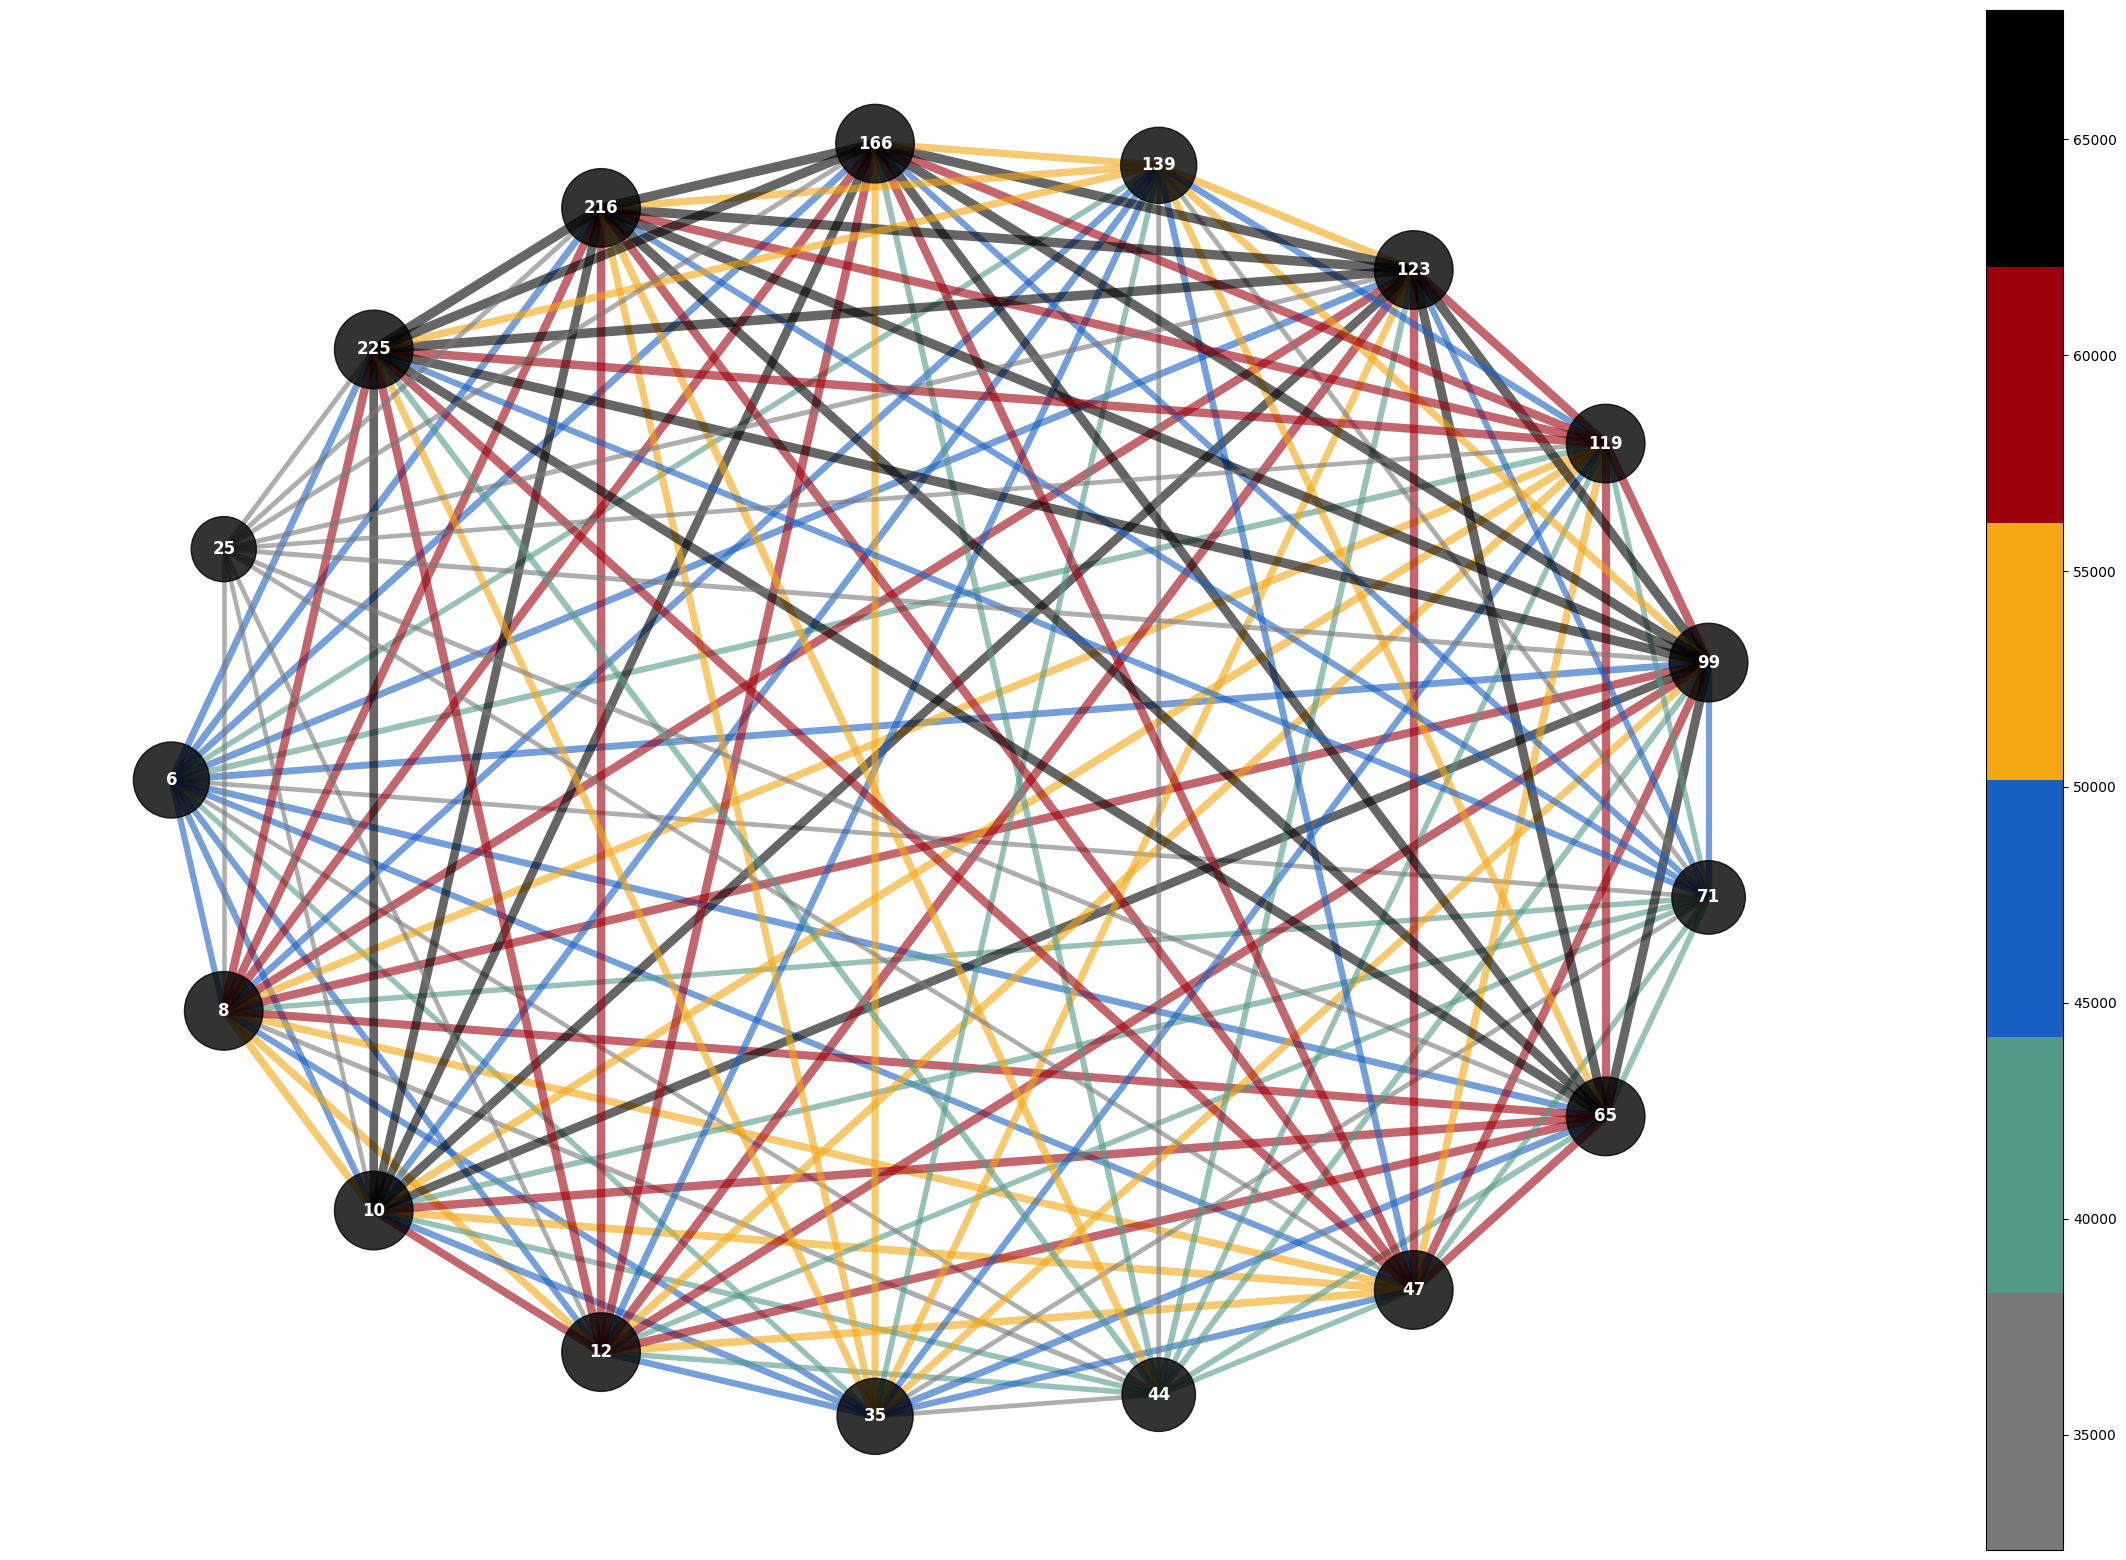

In [66]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.pyplot as plt

plt.subplots(figsize=(30,20))

# NODES
nodelist = G.nodes()
node_sizes = [max(1000, n_edges*200) for (_,n_edges) in dict(nx.degree(G)).items()]

# EDGES
widths = nx.get_edge_attributes(G, 'weight')
edges = G.edges()
edge_colors = [G[u][v]['weight'] for u,v in edges]
vmin, vmax = min(edge_colors), max(edge_colors)
cmap=plt.cm.RdYlGn
cmap = ListedColormap(["#797979", "#539987", "#1860C2", "#F3A712", "#9C000C", "#000000"])
edge_widths = [max(0.4, width*0.0001) for width in list(widths.values())]

# GRAPH
pos = nx.shell_layout(G)
nx.draw_networkx_nodes(G,pos,
                       nodelist=nodelist,
                       node_size=node_sizes,
                       node_color='black',
                       alpha=0.8)

nx.draw_networkx_edges(G,pos,
                       edgelist = widths.keys(),
                       width=edge_widths,
                       alpha=0.6, edge_color=edge_colors, edge_cmap=cmap)

nx.draw_networkx_labels(G, pos=pos,
                        labels=dict(zip(nodelist,nodelist)),
                        font_color='white', font_size = 12, font_weight = 'bold')


sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm)

plt.box(False)
plt.show()
# plt.savefig("Graph.svg", format="SVG")

One of the significant reasons of selecting the multi-label RFC classifier is that it implicitly learns class co-occurrence correlations when predicting the labels of a certain sample. Refer to other notebooks, and the paper for more

# Train, Predict, Eval Pipeline

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, matthews_corrcoef, confusion_matrix
from scipy.stats import entropy

def prepare_train_test(df, Y_NAME):
    ml_binner = MultiLabelBinarizer()
    ml_binner.fit(df[Y_NAME])
    y = ml_binner.transform(df[Y_NAME])
    X = df[FEATURE_NAMES].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    return X_train, X_test, y_train, y_test, ml_binner

def get_confusion(y_true, y_pred):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    return TN, TP, FN, FP

def calc_wba_wmcc_conf(y_true, y_pred):
    """Calculated the weighted balanced accuracy and mathews correlation coefficient
    """
    n_lst = []
    ba_lst = []
    mcc_lst = []
    tn_lst = []
    tp_lst = []
    fn_lst = []
    fp_lst = []
    for idx in range(y_true.shape[1]):
        class_true = y_true[:, idx]
        class_preds = y_pred[:, idx]
        N = sum(class_true)
        BA = balanced_accuracy_score(class_true, class_preds, adjusted=False)
        MCC = matthews_corrcoef(class_true, class_preds)
        TN, TP, FN, FP = get_confusion(class_true, class_preds)

        n_lst.append(N)
        mcc_lst.append(MCC)
        ba_lst.append(BA)

        tn_lst.append(TN)
        tp_lst.append(TP)
        fn_lst.append(FN)
        fp_lst.append(FP)

    weighted_balanced_acc = sum([n*ba for n,ba in zip(n_lst,ba_lst)]) / sum(sum(y_true))
    weighted_mcc = sum([n*mcc for n,mcc in zip(n_lst, mcc_lst)]) / sum(sum(y_true))
    sum_tn = sum(tn_lst)
    sum_tp = sum(tp_lst)
    sum_fn = sum(fn_lst)
    sum_fp = sum(fp_lst)

    return weighted_balanced_acc, weighted_mcc, sum_tn, sum_tp, sum_fn, sum_fp


def evaluate(y_true, y_pred):
    """Calculate several evaluation metrics based on true and predicted labels.

    Parameters
    ----------
    y_true : array-like of shape (n_samples, n_classes)
        True labels.
    y_pred : array-like of shape (n_samples, n_classes)
        Predicted labels.

    Returns
    -------
    metrics : dict
        A dictionary containing the following evaluation metrics:
            - 'WMCC' : float
                Weighted Matthews correlation coefficient.
            - 'WBA' : float
                Weighted balanced accuracy.
            - 'TN' : int
                Number of true negatives.
            - 'TP' : int
                Number of true positives.
            - 'FN' : int
                Number of false negatives.
            - 'FP' : int
                Number of false positives.
    """
    WBA, WMCC, TN, TP, FN, FP = calc_wba_wmcc_conf(y_true, y_pred)
    metrics = {
        "WMCC": WMCC ,
        "WBA": WBA,
        "TN":TN,
        "TP":TP, 
        "FN":FN,
        "FP":FP
    }
    return metrics

`For Ternary`

In [ ]:
X_train, X_test, y_train, y_test, ml_binner = prepare_train_test(df_agg, 'space_group_number')
clf = RandomForestClassifier(n_estimators=20, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
sg_eval_dict = evaluate(y_test, y_pred)

In [ ]:
X_train, X_test, y_train, y_test, ml_binner = prepare_train_test(df_agg, 'point_group')
clf = RandomForestClassifier(n_estimators=20, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
pg_eval_dict = evaluate(y_test, y_pred)

In [ ]:
X_train, X_test, y_train, y_test, ml_binner = prepare_train_test(df_agg, 'bravais_lattice')
clf = RandomForestClassifier(n_estimators=20, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
bl_eval_dict = evaluate(y_test, y_pred)

In [ ]:
X_train, X_test, y_train, y_test, ml_binner = prepare_train_test(df_agg, 'crystal_system')
clf = RandomForestClassifier(n_estimators=20, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
cs_eval_dict = evaluate(y_test, y_pred)

In [62]:
cs_eval_dict['Variable'] = 'Crystal System'
pg_eval_dict['Variable'] = 'Point Group'
bl_eval_dict['Variable'] = 'Bravais Lattice'
sg_eval_dict['Variable'] = 'Space Group'

In [79]:
import plotly.figure_factory as ff

eval_lst = [cs_eval_dict, bl_eval_dict, pg_eval_dict, sg_eval_dict]
df_eval = pd.DataFrame(eval_lst).round(2)
fig = ff.create_table([df_eval.columns.tolist()] + df_eval.values.tolist())
fig.show()

`For Binary`

In [91]:
FEATURE_NAMES = df_cs_bin.iloc[:, 1:11].columns.tolist()

# SG
df_sg_med = df_sg_bin.iloc[:, 11:].replace(1, pd.Series(df_sg_bin.columns, df_sg_bin.columns))
df_sg_bin['SG'] = df_sg_med.agg(lambda x: [i for i in list(x) if i != 0][0], axis=1).astype(str)
df_sg_bin = df_sg_bin.loc[:, FEATURE_NAMES+['SG']].copy()

# CS
df_cs_med = df_cs_bin.iloc[:, 11:].replace(1, pd.Series(df_cs_bin.columns, df_cs_bin.columns))
df_cs_bin['CS'] = df_cs_med.agg(lambda x: [i for i in list(x) if i != 0][0], axis=1)
df_cs_bin = df_cs_bin.loc[:, FEATURE_NAMES+['CS']].copy()

# BL
df_bl_med = df_bl_bin.iloc[:, 11:].replace(1, pd.Series(df_bl_bin.columns, df_bl_bin.columns))
df_bl_bin['BL'] = df_bl_med.agg(lambda x: [i for i in list(x) if i != 0][0], axis=1)
df_bl_bin = df_bl_bin.loc[:, FEATURE_NAMES+['BL']].copy()

# PG
df_pg_med = df_pg_bin.iloc[:, 11:].replace(1, pd.Series(df_pg_bin.columns, df_pg_bin.columns))
df_pg_bin['PG'] = df_pg_med.agg(lambda x: [i for i in list(x) if i != 0][0], axis=1)
df_pg_bin = df_pg_bin.loc[:, FEATURE_NAMES+['PG']].copy()


Y_NAME = "SG"
df_filtered_sg = filter_y(df_sg_bin, 50, Y_NAME)
df_agg_sg = df_filtered_sg.groupby(FEATURE_NAMES)[Y_NAME].apply(list).reset_index()

Y_NAME = "PG"
df_filtered_pg = filter_y(df_pg_bin, 50, Y_NAME)
df_agg_pg = df_filtered_pg.groupby(FEATURE_NAMES)[Y_NAME].apply(list).reset_index()

Y_NAME = "BL"
df_filtered_bl = filter_y(df_bl_bin, 50, Y_NAME)
df_agg_bl = df_filtered_bl.groupby(FEATURE_NAMES)[Y_NAME].apply(list).reset_index()

Y_NAME = "CS"
df_filtered_cs = filter_y(df_cs_bin, 50, Y_NAME)
df_agg_cs = df_filtered_cs.groupby(FEATURE_NAMES)[Y_NAME].apply(list).reset_index()

In [93]:
sg_count = df_agg_sg["SG"].explode().value_counts()
pg_count = df_agg_pg["PG"].explode().value_counts()
bl_count = df_agg_bl["BL"].explode().value_counts()
cs_count = df_agg_cs["CS"].explode().value_counts()


fig = px.bar(sg_count, title='Space Group Class Distribution', width=1700)
fig.update_xaxes(type='category', title='Label')
fig.update_yaxes(title='Size')
fig.update_traces(marker_color='#29335C')
fig.update_layout(showlegend=False)
# fig.write_image("sg_class_distrib.svg")
fig.show()

fig = px.bar(pg_count, title='Point Group Class Distribution', width=1700)
fig.update_xaxes(type='category', title='Label')
fig.update_yaxes(title='Size')
fig.update_traces(marker_color='#DB2B39')
fig.update_layout(showlegend=False)
# fig.write_image("pg_class_distrib.svg")
fig.show()

fig = px.bar(bl_count, title='Bravais Lattice Class Distribution', width=1700)
fig.update_xaxes(type='category', title='Label')
fig.update_yaxes(title='Size')
fig.update_traces(marker_color='#539987')
fig.update_layout(showlegend=False)
# fig.write_image("bl_class_distrib.svg")
fig.show()

fig = px.bar(cs_count, title='Crystal System Class Distribution', width=1700)
fig.update_xaxes(type='category', title='Label')
fig.update_yaxes(title='Size')
fig.update_traces(marker_color='#F3A712')
fig.update_layout(showlegend=False)
# fig.write_image("cs_class_distrib.svg")
fig.show()

In [95]:
# TRAIN
Y_NAME = "CS"
X_train, X_test, y_train, y_test, ml_binner = prepare_train_test(df_agg_cs, Y_NAME)
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# EVAL
cs_eval_dict = evaluate(y_test, y_pred)
cs_eval_dict["WMCC"] = ( cs_eval_dict["WMCC"] + 1) / 2
# --------------------------

# TRAIN
Y_NAME = "BL"
X_train, X_test, y_train, y_test, ml_binner = prepare_train_test(df_agg_bl, Y_NAME)
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# EVAL
bl_eval_dict = evaluate(y_test, y_pred)
bl_eval_dict["WMCC"] = ( bl_eval_dict["WMCC"] + 1) / 2
# --------------------------

# TRAIN
Y_NAME = "PG"
X_train, X_test, y_train, y_test, ml_binner = prepare_train_test(df_agg_pg, Y_NAME)
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# EVAL
pg_eval_dict = evaluate(y_test, y_pred)
pg_eval_dict["WMCC"] = ( pg_eval_dict["WMCC"] + 1) / 2
# --------------------------

# TRAIN
Y_NAME = "SG"
X_train, X_test, y_train, y_test, ml_binner = prepare_train_test(df_agg_sg, Y_NAME)
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# EVAL
sg_eval_dict = evaluate(y_test, y_pred)
sg_eval_dict["WMCC"] = ( sg_eval_dict["WMCC"] + 1) / 2
# --------------------------

In [96]:
print(df_agg_cs['CS'].explode().unique().shape[0])
print(pd.DataFrame(cs_eval_dict, index=["CS"])[['WMCC', "WBA"]])
print()

print(df_agg_bl['BL'].explode().unique().shape[0])
print(pd.DataFrame(bl_eval_dict, index=["BL"])[['WMCC', "WBA"]])
print()

print(df_agg_pg['PG'].explode().unique().shape[0])
print(pd.DataFrame(pg_eval_dict, index=["PG"])[['WMCC', "WBA"]])
print()

print(df_agg_sg['SG'].explode().unique().shape[0])
print(pd.DataFrame(sg_eval_dict, index=["SG"])[['WMCC', "WBA"]])
print()

5
        WMCC       WBA
CS  0.829054  0.826354

13
        WMCC      WBA
BL  0.802032  0.79754

12
        WMCC       WBA
PG  0.810062  0.809006

23
        WMCC       WBA
SG  0.806043  0.803483

